<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Final_16k_CNN_tuned_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

def get_data():

  data_set=torch.load('/content/gdrive/My Drive/Colab Notebooks/APS360 GROUP/additional-8k.pt')
  data_set=data_set+torch.load('/content/gdrive/My Drive/Colab Notebooks/APS360 GROUP/1k-images.pt')
  return  data_set

Data Loading and Splitting

In [4]:
# Prepare Dataloader
def get_data_loader( classes , batchsize, dataset):

  indices = np.arange(len(dataset))

# Split into train and validation  test
  np.random.seed(20) # Fixed numpy random seed for reproducible shuffling
  np.random.shuffle(indices)
  split = int(len(indices) * 0.6) #split at 60%
  split2=int(len(indices)*0.8)

#  # split into training and validationand test indices
  relevant_train_indices, relevant_val_indices  ,relevant_test_indices = indices[:split], indices[split:split2] , indices[split2:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,num_workers=1, sampler=train_sampler)
                                      
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                              num_workers=1, sampler=val_sampler)
  # # Get the list of indices to sample from
  
  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                          num_workers=1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

In [7]:
# # Verification Step - obtain one batch of images
def verify(data_loader,classes):

  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()

  images = images.numpy()
  
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(images[idx])
      ax.set_title(classes[labels[idx]])

In [2]:
# Prepare Dataset
dataset= get_data()


In [ ]:
# Prepare DataLoader
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=32, dataset=dataset)

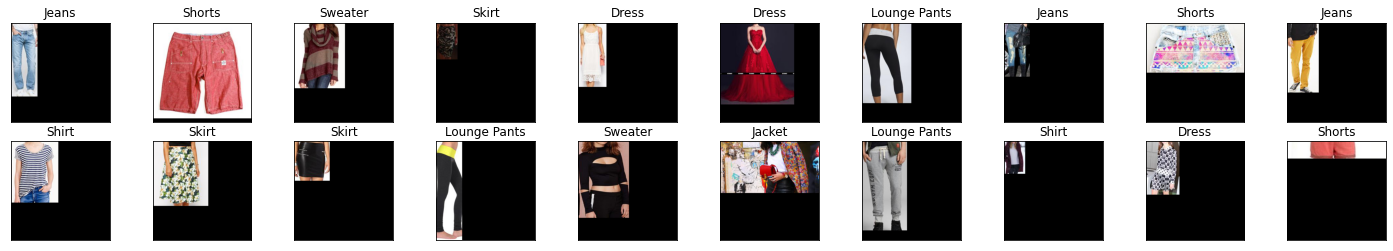

In [8]:
verify(train_loader,classes)


In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name="CNN"

        self.conv1 = nn.Conv2d(3, 5, 8)
        self.conv2 = nn.Conv2d(5, 13, 4)
        self.conv3 = nn.Conv2d(13, 20, 4)

        self.pool1 = nn.MaxPool2d(4, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(20* 32* 32, 200)
        self.fc2 = nn.Linear(200, 8)

    def forward(self, x):
        
        x = self.pool2(F.relu(self.conv1(x)))

        x = self.pool1(F.relu(self.conv2(x)))


        x=x.reshape(((x.shape[0], -1)))
        #x = x.view(-1, 20* 32* 32) #flatten feature data
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [42]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        imgs=imgs.permute(0,3,1,2)
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [38]:
def train_net(model,target_classes,train_loader,val_loader, batch_size=64, learn_rate=0.001, num_epochs=30):
    ########################################################################
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy,which will apply softmax to the output layer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time=time.time()
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):
            imgs=imgs.permute(0,3,1,2)
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_loss[epoch] = float(total_train_loss) / (batch_size)
        train_acc[epoch]= get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    end_time= time.time()

    # Write the train/test loss/err into CSV file 
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time: " , (end_time-start_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1: Train acc: 0.47302083333333333, Train loss: 15.276966229081154 |Validation acc: 0.4440625
Epoch 2: Train acc: 0.560625, Train loss: 12.301274860277772 |Validation acc: 0.51125
Epoch 3: Train acc: 0.6534375, Train loss: 10.422092400491238 |Validation acc: 0.5165625
Epoch 4: Train acc: 0.7280208333333333, Train loss: 8.774390693753958 |Validation acc: 0.5471875
Epoch 5: Train acc: 0.8092708333333334, Train loss: 7.2260224018245935 |Validation acc: 0.54875
Epoch 6: Train acc: 0.85, Train loss: 5.511471917852759 |Validation acc: 0.5478125
Epoch 7: Train acc: 0.9027083333333333, Train loss: 4.021427213214338 |Validation acc: 0.5390625
Epoch 8: Train acc: 0.9114583333333334, Train loss: 2.8112416135845706 |Validation acc: 0.5459375
Epoch 9: Train acc: 0.9507291666666666, Train loss: 2.241649235249497 |Validation acc: 0.5471875
Epoch 10: Train acc: 0.955, Train loss: 1.8701115243602544 |Validation acc: 0.52
Epoch 11: Train acc: 0.9715625, Train loss: 1.166249788569985 |Validation acc

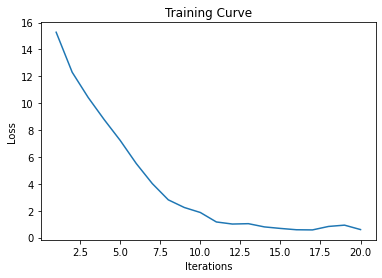

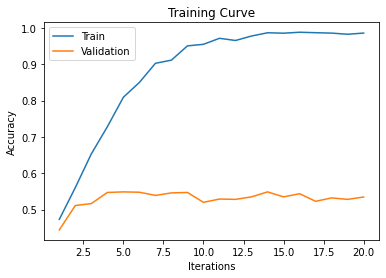

In [59]:
use_cuda = True
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']

model=CNN()

if use_cuda and torch.cuda.is_available():
    model.cuda()
train_net(model, classes,train_loader, val_loader, batch_size=32, num_epochs=20, learn_rate = 0.001)

In [60]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CNN_16k")

In [61]:
model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/CNN_16k"))

<All keys matched successfully>

In [62]:
get_accuracy(model,test_loader)

0.5325

In [66]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        imgs=imgs.permute(0,3,1,2)
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[157.,   5.,   3.,  25.,  30.,  85.,  22.,  94.],
        [  7., 248., 115.,  10.,   9.,   4.,  14.,  14.],
        [  3., 117., 214.,  20.,  25.,   3.,   5.,  19.],
        [  3.,  25.,  24., 239.,  55.,   9.,   6.,  17.],
        [ 17.,  19.,  18.,  79., 175.,  15.,  34.,  37.],
        [ 49.,  10.,   6.,  11.,  28., 152.,  18., 114.],
        [ 14.,  13.,  13.,   5.,  14.,  14., 280.,  54.],
        [ 33.,   7.,   7.,   5.,  11.,  59.,  24., 239.]])
tensor([0.3729, 0.5891, 0.5271, 0.6323, 0.4442, 0.3918, 0.6880, 0.6208])


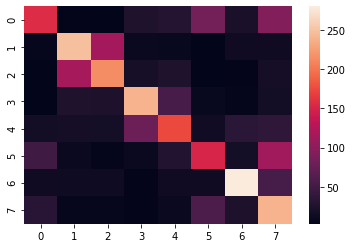

In [67]:
get_confusion_matrix(model,test_loader)